In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy import signal
import librosa
import IPython.display

Text(0.5, 1.0, 'Frequency response of pre-emphasis filter H(z) = 1 - p z^{-1} (p=0.97)')

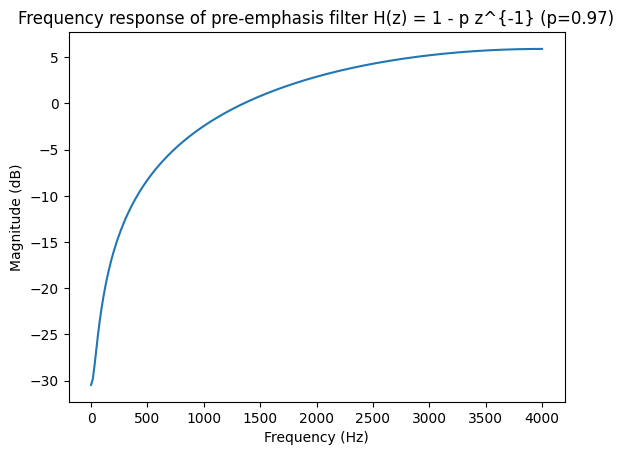

In [2]:
# サンプリング周波数 [Hz]
# ここでは 8 kHz の音声を想定している
sr = 8000

# FFT のポイント数
# rFFT の結果は 0〜ナイキスト（sr/2）までの nFFT/2+1 点になる
nFFT = 512

# 周波数軸を生成
# np.fft.rfftfreq(nFFT, 1/sr) は rFFT の各ビンに対応する周波数 [Hz] を返す
f = np.fft.rfftfreq(nFFT, 1 / sr)

# プリエンファシス係数 p
# 1 サンプル前との差分をとる 1 次の FIR フィルタ
#   H(z) = 1 - p z^{-1}
# を使うとき、p ≒ 0.95〜0.97 がよく使われる。
# 高周波側を持ち上げて、音声のスペクトル包絡（フォルマント）解析をしやすくする目的がある。
p = 0.97

# フィルタのインパルス応答（FIR 係数）を長さ 2 の配列で表現
# [1, -p] は
#   y[n] = x[n] - p x[n-1]
# という 1 次差分型の高域強調フィルタに対応する。
h = [1, -p]

# インパルス応答 h の周波数応答を rFFT で計算する
#   S[k] = Σ_n h[n] e^{-j 2π k n / nFFT}
# ここでは nFFT 点で評価しているので周波数分解能は sr/nFFT [Hz] になる。
S = np.fft.rfft(h, nFFT)

# 振幅スペクトルの大きさ |S(f)| を dB スケールでプロット
# 20*log10(|S|) とすることで、振幅の比をデシベル表現に変換している
# このフィルタは高域になるほどゲインが大きくなる高域強調（ハイパスに近い）特性を持つ。
plt.plot(f, 20 * np.log10(np.abs(S)))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Frequency response of pre-emphasis filter H(z) = 1 - p z^{-1} (p=0.97)")

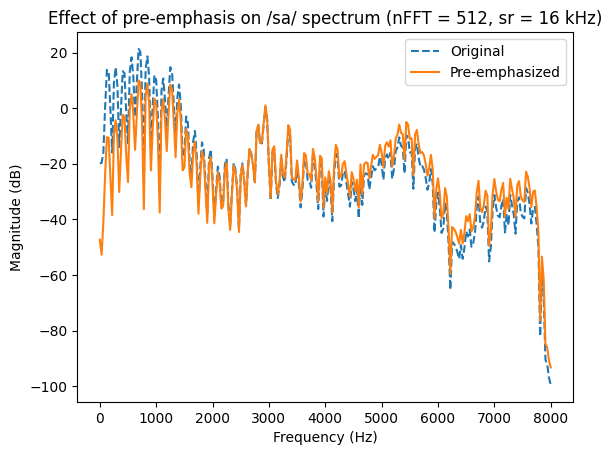

In [4]:
# 以前の図を閉じて、今回のプロットだけが表示されるようにする
plt.close()

# -------------------------------------------------------
# 1. /sa/ 音声の読み込みと解析フレームの設定
# -------------------------------------------------------
# 'sa48k.wav' をサンプリング周波数 16 kHz にリサンプリングして読み込む
#   ySa : 音声波形（1 次元 numpy 配列）
#   sr  : 実際に読み込まれたサンプリングレート（ここでは 16000 Hz になる）
ySa, sr = librosa.load("sa48k.wav", sr=16000)

# FFT サイズ（＝解析フレーム長）を 512 サンプルに設定
#   512 サンプル / 16000 Hz ≒ 32 ms の時間窓
nFFT = 512

# -------------------------------------------------------
# 2. プリエンファシス前のスペクトル（元の波形）
# -------------------------------------------------------
# 解析フレームとして、サンプルインデックス 7500 から 512 サンプル分を取り出す
#   7500 / 16000 ≒ 0.47 s 以降の約 32 ms 区間を見ている
frame = ySa[7500 + np.arange(nFFT)]

# ハニング窓を掛けてから rFFT を取る
#   ・窓を掛ける → フレーム両端で滑らかに 0 に近づけ、スペクトルリークを抑える
#   ・np.fft.rfft → 実信号に対する片側スペクトル（0〜ナイキスト）を計算
SSa = np.fft.rfft(frame * np.hanning(nFFT))

# -------------------------------------------------------
# 3. プリエンファシス（高域強調フィルタ）の適用
# -------------------------------------------------------
# ySaEmphasis : プリエンファシス後の波形
#   フィルタ H(z) = 1 - p z^{-1} を適用している
#   y[n] = x[n] - p x[n-1]
#   p は前セルで定義したプリエンファシス係数（例: p = 0.97）を想定
ySaEmphasis = signal.lfilter([1, -p], 1, ySa)

# 同じ位置（7500 サンプル目付近）から、プリエンファシス後のフレームを取り出す
frame_emph = ySaEmphasis[7500 + np.arange(nFFT)]

# ハニング窓を掛けて rFFT を計算
SSaEmphasis = np.fft.rfft(frame_emph * np.hanning(nFFT))

# -------------------------------------------------------
# 4. 周波数軸の生成と、振幅スペクトルの dB プロット
# -------------------------------------------------------
# rFFT の各ビンに対応する周波数 [Hz] を計算
#   Δf = sr / nFFT で一定間隔の周波数グリッドになる
frequency = np.fft.rfftfreq(nFFT, 1 / sr)

# 元のスペクトル（プリエンファシスなし）の振幅特性を dB で描画
#   20 log10 |S(f)| で振幅の比をデシベル表現に変換
#   '--' で破線にして、あとから描くプリエンファシス後と区別
plt.plot(frequency, 20 * np.log10(np.abs(SSa)), "--", label="Original")

# プリエンファシス後のスペクトルを重ねて描画
#   高周波数側の成分が持ち上がり、スペクトル包絡がフラットに近づくことが期待される
plt.plot(frequency, 20 * np.log10(np.abs(SSaEmphasis)), label="Pre-emphasized")

# 軸ラベルや凡例などを整える
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Effect of pre-emphasis on /sa/ spectrum (nFFT = 512, sr = 16 kHz)")
plt.legend()

# この図により、
#   ・元の音声スペクトルでは高域が弱く、低域にエネルギーが集中している
#   ・プリエンファシス後は高域が相対的に持ち上がり、スペクトル包絡がなだらかになる
# といった「高域強調フィルタの目的と効果」を視覚的に確認できる。

Text(0.5, 1.0, 'Magnitude spectrum of windowed white noise (nFFT = 512, sr = 16 kHz)')

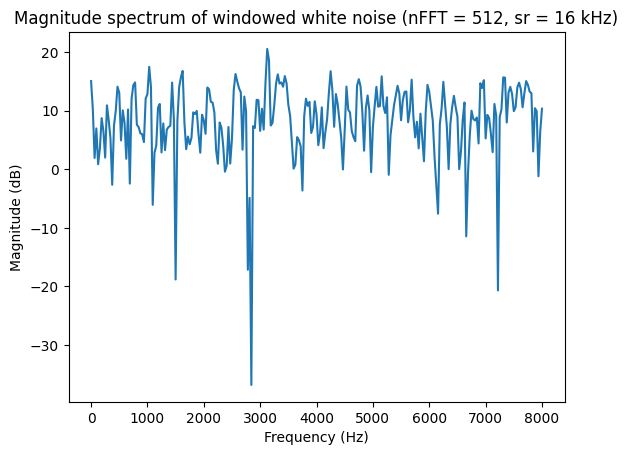

In [5]:
plt.close()  # それまでに開いていたプロットウィンドウを全て閉じて、グラフ描画状態をリセットする

sr = 16000  # サンプリング周波数 [Hz]。ここでは 16 kHz として 1 秒間のホワイトノイズを生成する
t = np.linspace(0, 1, sr + 1)  # 時間軸（0〜1 秒）を sr+1 個の等間隔サンプルで生成

# 標準正規分布 N(0,1) に従う乱数列を生成（理論的には「ホワイトノイズ」）
r = np.random.standard_normal(t.shape)

# 振幅の最大値がほぼ 1 になるように正規化
# 1.01 を掛けているのは、最大値ギリギリでクリップしないように少し余裕を持たせるため
r = r / np.max(np.abs(r) * 1.01)

nFFT = 512  # FFT のサンプル数。ここでは先頭 512 サンプルだけを使って周波数特性を見る

# 先頭 512 サンプルに Hann 窓を掛けてから実数 FFT（rFFT）を計算
# ・Hann 窓を掛けることでフレーム端の不連続性を抑え、スペクトルリークを軽減する
# ・SR は複素数スペクトルで、振幅と位相の情報を持つ
SR = np.fft.rfft(r[:nFFT] * np.hanning(nFFT))

# rFFT に対応する周波数軸を生成
# 0 Hz 〜 sr/2 Hz までが等間隔に並ぶ
frequency = np.fft.rfftfreq(nFFT, 1 / sr)

# 振幅スペクトル |SR(f)| を dB スケールでプロット
# ホワイトノイズなので、理論的には全帯域でほぼフラットなスペクトルが期待される
# （有限長 + 窓の影響で実際には多少の凹凸が見える）
plt.plot(
    frequency, 20 * np.log10(np.abs(SR) + 1e-12)
)  # 1e-12 を足して log(0) による -inf を防止
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Magnitude spectrum of windowed white noise (nFFT = 512, sr = 16 kHz)")

Text(0.5, 1.0, 'Normalized triangular window (time-domain shape)')

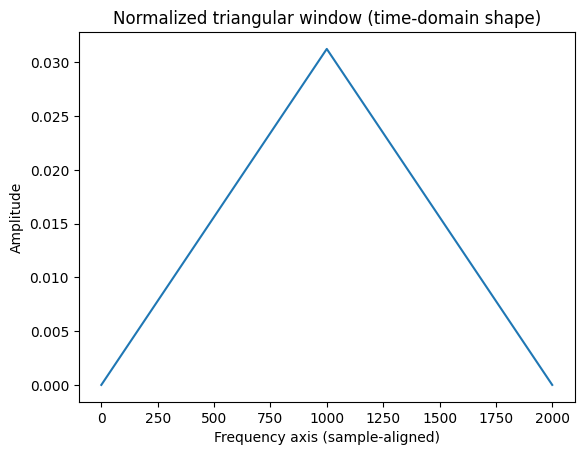

In [6]:
plt.close()  # それまでに開いていた図を全て閉じて、描画状態をリセットする

# ここでは、先ほど FFT に使った nFFT を基準にして「時間窓」の長さを決める
# nFFT = 512 とすると nWindow = 64 となり、64 サンプル長の三角窓を定義することになる
nWindow = int(nFFT / 8)

# 三角窓の前半（立ち上がり部分）を 0 → 1 で線形に生成
# サンプル数は nWindow/2 + 1 個（例: 32 + 1 = 33 個）
windowInc = np.linspace(0, 1, int(nWindow / 2) + 1)

# 三角窓の後半（立ち下がり部分）を 1 → 0 で線形に生成
# こちらも同じく nWindow/2 + 1 個
windowDec = np.linspace(1, 0, int(nWindow / 2) + 1)

# 立ち上がりと立ち下がりを繋いで、1 点重なる頂点（windowDec[0]）を除いて連結する
# これにより、0 → 1 → 0 の山型（三角形）窓が得られる
windowTri = np.hstack((windowInc, windowDec[1:]))

# 窓の総和が 1 になるように正規化する
# ・この正規化を行うと、「窓を掛けても平均エネルギーが大きく変わらない」
#   といった性質を持たせやすくなる（単純な例として、移動平均フィルタと同様のスケールに合わせられる）
windowTriNormalized = windowTri / np.sum(windowTri)

# x 軸には先ほど定義した frequency をそのまま流用し、
# そのうち三角窓の長さに対応する部分だけをプロットする
# （ここでは「周波数軸上に三角形の形を載せている」だけで、周波数応答そのものではない点に注意）
plt.plot(frequency[: len(windowTriNormalized)], windowTriNormalized)
plt.xlabel("Frequency axis (sample-aligned)")
plt.ylabel("Amplitude")
plt.title("Normalized triangular window (time-domain shape)")

(6.0, 0.0)

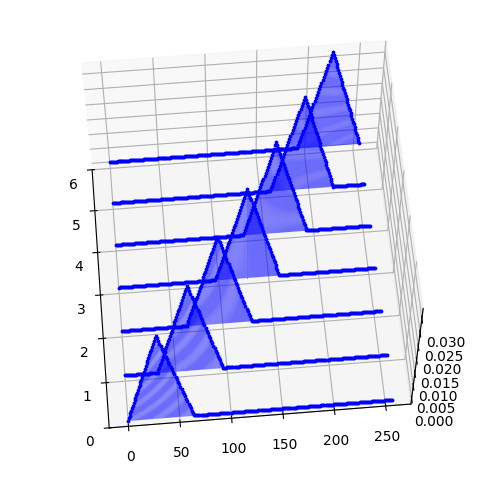

In [7]:
plt.close()  # これまでに表示されているすべての図を閉じて、描画状態をリセットする


def stem3(z):
    """
    3 次元の「stem プロット」（棒グラフのように、底から値まで縦に線を引くプロット）を描く関数。
    入力 z が
      - 1 次元配列: 周波数軸上の 1 本のフィルタなど
      - 2 次元配列: （フィルタ番号 × 周波数ビン）のフィルタバンク
    のどちらの場合でも、3D の棒グラフとして可視化できるようにしている。
    """
    # 元の線の太さ（linewidth）を退避しておき、最後に戻す
    orig_line_width = plt.rcParams["lines.linewidth"]
    plt.rcParams["lines.linewidth"] = 0.4  # stem 用の線を細くする

    # 3D プロット用の Figure / Axes を作成
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")

    # 入力 z の次元数によって、X, Y のサイズの解釈を変える
    if z.ndim == 1:
        # 1 次元の場合は「Y 方向に 1、本だけある」とみなす
        Y = 1
        X = z.shape[0]
    else:
        # 2 次元の場合は「X: 周波数ビン数、Y: フィルタ番号」の行列として扱う
        X, Y = z.shape

    # 各 (x, y) に対して stem（棒）を描画する
    for x in range(X):
        for y in range(Y):
            if Y == 1:
                # 1 次元の場合: y 座標は 0 固定（1 本の列として描画）
                #   [x, x],[y, y] は水平位置（x, y）を固定し、
                #   z 軸方向に 0 から z[x] まで線分を描く
                ax.plot([x, x], [y, y], [0, z[x]], "b-")
                # 先端に小さな点を打つ
                ax.scatter(x, y, z[x], s=3, color="b")
            else:
                # 2 次元の場合: (x, y) ごとに z[x, y] までの縦線を引く
                ax.plot([x, x], [y, y], [0, z[x, y]], "b-")
                ax.scatter(x, y, z[x, y], s=3, color="b")

    # linewidth を元の値に戻しておく（他のグラフへの影響を避ける）
    plt.rcParams["lines.linewidth"] = orig_line_width
    return fig, ax  # 呼び出し元で図や軸の設定を続行できるように返す


# -------------------------------------------------------
# 三角窓を並べたフィルタバンク（周波数領域のバンドパス群）を作る
# -------------------------------------------------------

# 各フィルタの中心周波数ビンのインデックスを計算
#   nWindow/2 刻みで、nFFT/2（ナイキスト周波数）まで等間隔に並べる
#   → 低域〜高域まで、三角窓の中心がずらっと並んだフィルタバンクになる
center = np.arange(nWindow / 2, nFFT / 2, nWindow / 2).astype(int)

# フィルタバンク用の配列を初期化
#   行   : フィルタ番号（len(center) 本）
#   列   : 周波数ビン（0〜ナイキストまでで nFFT/2+1 ビン）
filterBank = np.zeros((len(center), int(nFFT / 2) + 1))

# 各フィルタに対して、対応する三角窓（windowTriNormalized）を
# 周波数軸上の適切な位置に貼り付けていく
for iFilter in np.arange(len(center)):
    # iFilter 番目のフィルタの開始インデックス
    #   中心 center[iFilter] から左右に nWindow/2 だけ広がるようにする
    iStart = int(center[iFilter] - nWindow / 2)

    # filterBank の該当区間に、正規化三角窓をそのままコピー
    #   この結果、各行が「特定帯域だけを通す三角形状のバンドパス」を表す
    #   （メルフィルタバンクと同じ思想の、等間隔線形フィルタ版）
    filterBank[iFilter, iStart : (iStart + nWindow + 1)] = windowTriNormalized

# -------------------------------------------------------
# 3D stem プロットでフィルタバンクを可視化
# -------------------------------------------------------

fig, ax = stem3(filterBank)  # 行列 filterBank を 3D 棒グラフとして描画
fig.set_figheight(6)  # 図の高さを設定（インチ単位）
fig.set_figwidth(6)  # 図の幅を設定（インチ単位）

# 3D の縦横比を設定
#   (X方向, Y方向, Z方向) の比率。
#   X, Y を大きく、Z をやや低めにして、バンク全体の形が見やすいようにしている。
ax.set_box_aspect(aspect=(60, 60, 40))

# 視点の設定：
#   elev: 上から見下ろす角度（高度）
#   azim: 水平方向の回転角度
ax.view_init(elev=60, azim=-5)

# x 軸の向きを反転（右から左に見えるように）して、図として見やすいレイアウトにする
ax.set_xlim(6, 0)

# 保存したい場合は以下のようにファイル出力も可能
# fig = plt.gcf()
# fig.savefig('fig05_14.eps')

Text(0.5, 1.0, 'Mel filter bank (48 filters, nFFT = 2048, sr = 48000 Hz)')

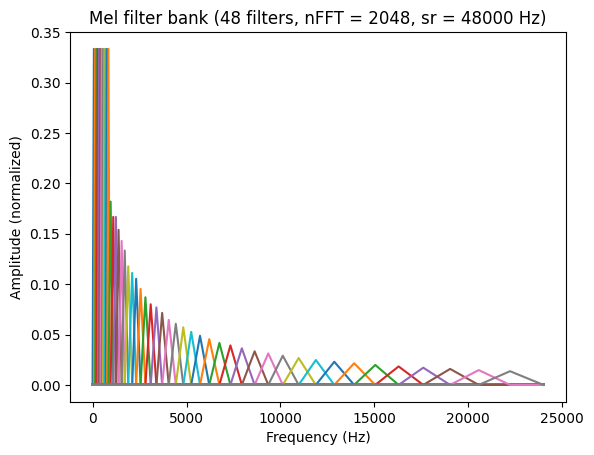

In [8]:
plt.close()
sr = 48000  # サンプリング周波数 [Hz]


# 周波数(Hz) → メル尺度 への変換関数
# メル尺度は人間のピッチ知覚に合わせた非線形軸で、
# 低周波数ではほぼ線形，高周波数では対数的に圧縮される。
def hz2mel(freq):
    return 1127 * np.log(1 + freq / 700)


# メル尺度 → 周波数(Hz) への逆変換関数
def mel2hz(mel):
    return (np.exp(mel / 1127) - 1) * 700


nFFT = 2048  # FFT のポイント数
nBank = 48  # メルフィルタバンクの本数
upper = sr / 2  # 解析上限周波数（ナイキスト周波数）
lower = 0  # 下限周波数（今回は 0 Hz）
# 0〜sr/2 を nFFT/2+1 ビンに均等分割した周波数軸
frequency = np.linspace(0, sr / 2, int(nFFT / 2) + 1)

# メルフィルタバンク（nBank × 周波数ビン数）の初期化
melFilterBank = np.zeros((nBank, int(nFFT / 2) + 1))

# ============================
# 低周波数側のフィルタ（ほぼ線形間隔）
# ============================

# 低域側フィルタの窓長（周波数ビン数）を決める
# 400/3 [Hz] 程度の帯域幅を，FFT の周波数分解能 sr/nFFT で割ってビン数に変換
nMelWindowLow = int(np.floor(400 / 3 / (sr / nFFT)))

# きれいな対称三角窓を作るため，窓長を偶数に揃える
if nMelWindowLow % 2 != 0:
    nMelWindowLow += 1

# 0 → 1 に線形増加する上り部分
windowMelIncLow = np.linspace(0, 1, int(nMelWindowLow / 2) + 1)
# 1 → 0 に線形減少する下り部分
windowMelDecLow = np.linspace(1, 0, int(nMelWindowLow / 2) + 1)

# 頂点の 1 が重複しないように，下り部分の先頭要素を除いて連結し三角窓を作成
windowMelTriLow = np.hstack((windowMelIncLow, windowMelDecLow[1:]))

# 各フィルタの重みの総和が 1 になるように正規化
# （この正規化により「加重平均」として解釈しやすくなる）
windowMelTriLowNormalized = windowMelTriLow / np.sum(windowMelTriLow)

# 低域側のフィルタ中心ビンのインデックス列
# nMelWindowLow/2 ごとにずらすことで，オーバーラップした三角窓列を構成
centerLow = np.arange(
    nMelWindowLow / 2, 13 * nMelWindowLow / 2, nMelWindowLow / 2
).astype(int)

# 低域側フィルタを melFilterBank の先頭から順に埋め込む
for iCenterLow in np.arange(len(centerLow)):
    # iCenterLow 番目フィルタの左端インデックス
    start = int(centerLow[iCenterLow] - nMelWindowLow / 2)
    # [start, start + nMelWindowLow] の区間に三角窓をコピー
    melFilterBank[iCenterLow, start : (start + nMelWindowLow + 1)] = (
        windowMelTriLowNormalized
    )

# ============================
# 高周波数側の「メル間隔」フィルタ
# ============================

# 全体のメル軸上の上限値（ナイキスト周波数をメルに変換）
upperMel = hz2mel(upper)
# 低域側最後のフィルタ中心周波数をメルに変換
lowerMel = hz2mel(frequency[centerLow[-1]])

# 残りのフィルタ本数をメル軸上で均等分割するためのステップ幅
stepMel = (upperMel - lowerMel) / (nBank + 1 - len(centerLow))

# lowerMel〜upperMel を stepMel ごとに刻んだメル値を Hz に戻し，
# それを FFT ビンインデックスに変換して「高域側中心ビン配列」を作る
center = np.round(
    mel2hz(np.arange(lowerMel, upperMel + 1, stepMel)) / (sr / 2) * (nFFT / 2)
).astype(int)

# center[0], center[1], center[2], ... を三つずつ使って
# 左・中央・右の 3 点で構成される三角フィルタを順に生成する
for iCenter in np.arange(len(center) - 2):
    # 三角窓の左端・中心・右端インデックス
    t0, t1, t2 = center[iCenter + [0, 1, 2]]

    # 対応するフィルタバンク行インデックス
    iCurrent = iCenterLow + iCenter + 1

    # 左端 t0 から中心 t1 まで 0 → 1 に線形に増加
    melFilterBank[iCurrent, t0 : (t1 + 1)] = np.linspace(0, 1, t1 - t0 + 1)

    # 中心 t1 から右端 t2 まで 1 → 0 に線形に減少
    melFilterBank[iCurrent, t1 : (t2 + 1)] = np.linspace(1, 0, t2 - t1 + 1)

    # 高域側フィルタも重みの総和が 1 になるよう正規化
    melFilterBank[iCurrent, :] = melFilterBank[iCurrent, :] / np.sum(
        melFilterBank[iCurrent, :]
    )

# 参考: フィルタ中心周波数を Hz で確認したい場合（現在は未使用）
# fC1 = mel2hz(frequency[centerLow])                  # 低域側中心
# fC2 = mel2hz(np.arange(lowerMel, upperMel+1, stepMel))  # 高域側中心
# fC  = np.hstack((fC1, fC2[1:-1]))                   # 両者を結合（端の重複を除去）

# ============================
# メルフィルタバンクの形状をプロット
# ============================
plt.figure()
# 各行（フィルタ）のゲインを周波数軸に重ね描きすることで，
# メルフィルタバンク全体の周波数応答を視覚化する
plt.plot(frequency, melFilterBank.T)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (normalized)")
plt.title("Mel filter bank ({} filters, nFFT = {}, sr = {} Hz)".format(nBank, nFFT, sr))
# 低域だけ見る場合などは xlim を設定すると良い
# plt.xlim([0, 6000])

# 図をファイルに保存したい場合の例
# fig = plt.gcf()
# fig.savefig('fig05_17.eps')

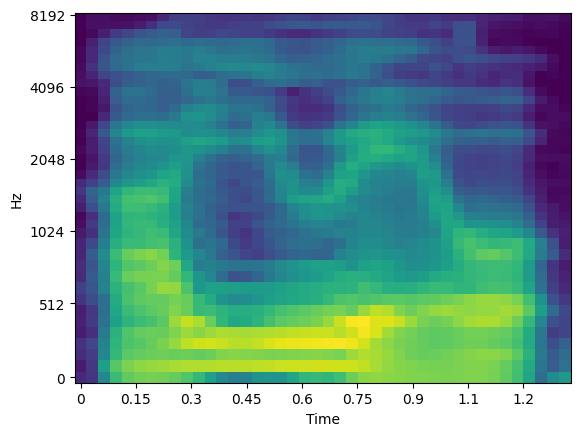

In [9]:
plt.close()

# 音声ファイル 'aiueo16k.wav' を読み込む
# y : 波形データ（1 次元配列）
# sr: サンプリング周波数 [Hz]（ここではファイル側の 16 kHz がそのまま入る想定）
y, sr = librosa.load("aiueo16k.wav", sr=None)

# メルフィルタバンクの本数（メル周波数軸上の解像度）
# 値を大きくすると周波数方向の分解能が上がるが、特徴次元も増える
nBank = 40

# メルスペクトログラムを計算する
# S: 形状 (n_mels, n_frames) の「パワー」メルスペクトログラム
#    - 短時間フーリエ変換(STFT)のパワースペクトルに
#      メルフィルタバンク（△フィルタ列）を掛けて周波数軸を圧縮したもの
#    - メル尺度は，人間の聴覚に近いピッチ知覚（低域は細かく，高域は粗く）を反映した周波数軸
S = librosa.feature.melspectrogram(
    y=y,
    sr=sr,
    n_mels=nBank,  # メルバンド数
    fmax=8000,  # 解析する上限周波数 [Hz]（ここでは 0〜8 kHz）
)

# パワースペクトログラムを dB スケールに変換
# - 対数変換することで，人間のラウドネス知覚（対数的）に近い表現になる
# - ref=np.max とすることで，全フレーム・全周波数の中で最大値を 0 dB として正規化
SdB = librosa.power_to_db(S, ref=np.max)

# メルスペクトログラムを画像として表示
# - x_axis='time' により横軸が時間[s]
# - y_axis='mel'  により縦軸がメル周波数[mel]
# - fmax=8000     により 0〜8 kHz 相当のメル帯域のみを表示
# - cmap='viridis' で色マップを指定（明るい色ほどエネルギー大）
librosa.display.specshow(
    SdB, sr=sr, fmax=8000, x_axis="time", y_axis="mel", cmap="viridis"
)

# この図は：
# - 横方向に時間変化（どのタイミングでどの周波数帯が強いか）
# - 縦方向にメル周波数（人間の聴覚に合わせた周波数軸）
# - 色の濃さでエネルギー量（dB）
# を表しており，音声認識や音声特徴量抽出（MFCC など）の前処理として
# 非常によく使われる表現となる。plt.close()

# 音声ファイル 'aiueo16k.wav' を読み込む
# y : 波形データ（1 次元配列）
# sr: サンプリング周波数 [Hz]（ここではファイル側の 16 kHz がそのまま入る想定）
y, sr = librosa.load("aiueo16k.wav", sr=None)

# メルフィルタバンクの本数（メル周波数軸上の解像度）
# 値を大きくすると周波数方向の分解能が上がるが、特徴次元も増える
nBank = 40

# メルスペクトログラムを計算する
# S: 形状 (n_mels, n_frames) の「パワー」メルスペクトログラム
#    - 短時間フーリエ変換(STFT)のパワースペクトルに
#      メルフィルタバンク（△フィルタ列）を掛けて周波数軸を圧縮したもの
#    - メル尺度は，人間の聴覚に近いピッチ知覚（低域は細かく，高域は粗く）を反映した周波数軸
S = librosa.feature.melspectrogram(
    y=y,
    sr=sr,
    n_mels=nBank,  # メルバンド数
    fmax=8000,  # 解析する上限周波数 [Hz]（ここでは 0〜8 kHz）
)

# パワースペクトログラムを dB スケールに変換
# - 対数変換することで，人間のラウドネス知覚（対数的）に近い表現になる
# - ref=np.max とすることで，全フレーム・全周波数の中で最大値を 0 dB として正規化
SdB = librosa.power_to_db(S, ref=np.max)

# メルスペクトログラムを画像として表示
# - x_axis='time' により横軸が時間[s]
# - y_axis='mel'  により縦軸がメル周波数[mel]
# - fmax=8000     により 0〜8 kHz 相当のメル帯域のみを表示
# - cmap='viridis' で色マップを指定（明るい色ほどエネルギー大）
librosa.display.specshow(
    SdB, sr=sr, fmax=8000, x_axis="time", y_axis="mel", cmap="viridis"
)

# この図は：
# - 横方向に時間変化（どのタイミングでどの周波数帯が強いか）
# - 縦方向にメル周波数（人間の聴覚に合わせた周波数軸）
# - 色の濃さでエネルギー量（dB）
# を表しており，音声認識や音声特徴量抽出（MFCC など）の前処理として
# 非常によく使われる表現となる。